**Datasets of character**

In [50]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import glob
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

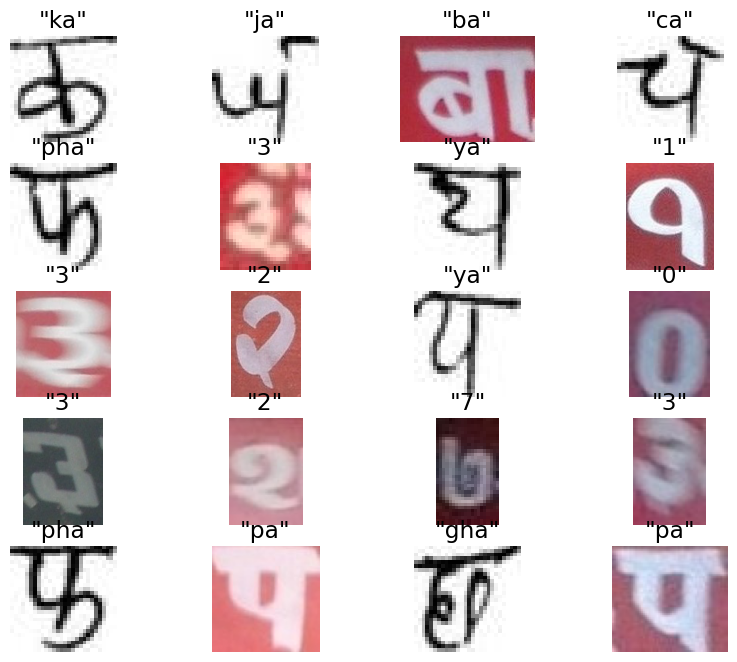

In [51]:

# dataset_paths = glob.glob("/content/drive/MyDrive/datasets/characters/**/*.jpg") # for google colab
dataset_paths = glob.glob('../Automatic-License-Plate-Detection-khom/character_recognition/characters/**/*.jpg')


cols=4
rows=5
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot example images
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

In [52]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))

[INFO] Find 3878 images with 21 classes


In [53]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [54]:
# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('../Automatic-License-Plate-Detection-khom/character_recognition/license_character_classes.npy', lb.classes_)

# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)


# generate data augumentation method
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

# Initialize MobileNets architecture with pre-trained weights
In this step, we construct our MobileNets architecture with pre-trained weights on imagenet dataset. The model can be imported directly from Keras Application package. There are several crucial elements that require to be noticed here:



*   Line 4~5: 

Discard the last output layers of default MobileNets architecture and replace it with our desired output layer (Line 12). Out output layer would contains 36 nodes associating to 36 characters. Recall that the shape of our input images are (80,80,3), we need to config our input layer as the same dimension (Line 5)

*   Line 16 ~ 23:

 If training=True, defining all layers in base_model as trainable layers (weight can be updated during training); initializing learning rate and decay value; and compiling our model with losses and metrics as categorical cross entropy and accuracy respectively


In [55]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

In [56]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
            
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

C:\Users\ACER\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [57]:
# !pip install image-generator

# Train and evaluate model

In [58]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="../Automatic-License-Plate-Detection-khom/character_recognition/khom_char.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
54/54 [==============================] - ETA: 0s - loss: 3.1008 - accuracy: 0.1284
Epoch 1: saving model to ../Automatic-License-Plate-Detection-khom/character_recognition\khom_char.h5
54/54 [==============================] - 70s 1s/step - loss: 3.1008 - accuracy: 0.1284 - val_loss: 3.5363 - val_accuracy: 0.0593
Epoch 2/30
54/54 [==============================] - ETA: 0s - loss: 2.2295 - accuracy: 0.2966
Epoch 2: saving model to ../Automatic-License-Plate-Detection-khom/character_recognition\khom_char.h5
54/54 [==============================] - 68s 1s/step - loss: 2.2295 - accuracy: 0.2966 - val_loss: 3.0304 - val_accuracy: 0.1082
Epoch 3/30
54/54 [==============================] - ETA: 0s - loss: 1.6275 - accuracy: 0.4936
Epoch 3: saving model to ../Automatic-License-Plate-Detection-khom/character_recognition\khom_char.h5
54/54 [==============================] - 67s 1s/step - loss: 1.6275 - accuracy: 0.4936 - val_loss: 2.5362 - val_accuracy: 0.2036
Epoch 4/30
54/54 [=======

13/13 - 1s - loss: 0.2981 - accuracy: 0.9407 - 1s/epoch - 114ms/step


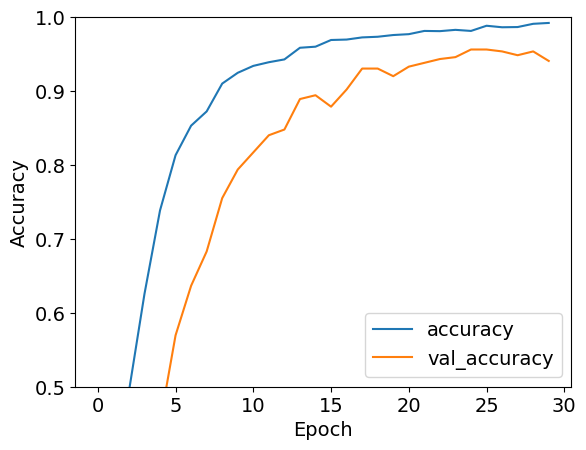

In [59]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(testX,  testY, verbose=2)

In [60]:
print(test_acc)

0.9407216310501099


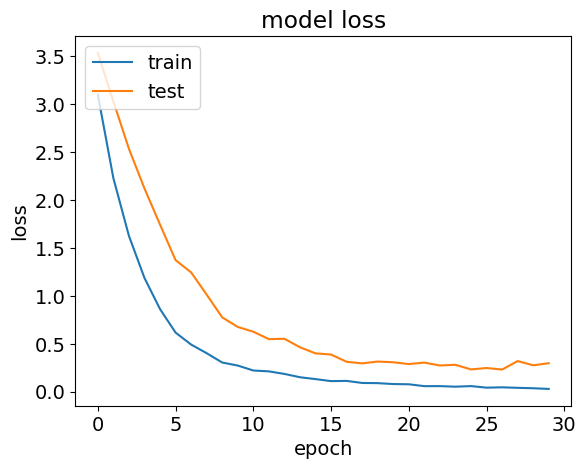

In [61]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Finally, model architecture need to be save so later we do not have to construct our model architecture from scratch. This act can be done with the snippet code as below:

In [62]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

# Combining everything
This series is coming to an end. To summarize, we manged to extract the plate license from vehicle image in Part 1, segment its character as Part 2 and train a CNN model to predict characters from images. To deliver prediction, first we would need to rebuild our model architecture (line 1 ~ 5), load saved weight after training phase (line 6) and origin label classes (line 9 ~ 10).

In [63]:
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder

# Load model architecture, weight and labels

json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# model.load_weights("../Automatic-License-Plate-Detection-khom/character_recognition/License_character_recognition.h5")
model.load_weights("../Automatic-License-Plate-Detection-khom/character_recognition/khom_char.h5")

print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('../Automatic-License-Plate-Detection-khom/character_recognition/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [64]:
testX[0]

array([[[232.,  40.,  55.],
        [232.,  40.,  55.],
        [234.,  42.,  57.],
        ...,
        [225.,  20.,  37.],
        [223.,  27.,  39.],
        [227.,  31.,  43.]],

       [[229.,  37.,  52.],
        [228.,  36.,  51.],
        [224.,  32.,  47.],
        ...,
        [225.,  24.,  42.],
        [229.,  34.,  48.],
        [229.,  34.,  48.]],

       [[212.,  20.,  33.],
        [216.,  24.,  37.],
        [221.,  29.,  42.],
        ...,
        [224.,  33.,  49.],
        [209.,  20.,  38.],
        [207.,  18.,  36.]],

       ...,

       [[229., 102., 113.],
        [230., 103., 114.],
        [230., 103., 114.],
        ...,
        [228., 102., 116.],
        [226., 102., 112.],
        [225., 101., 111.]],

       [[227., 101., 112.],
        [225.,  99., 110.],
        [232., 106., 117.],
        ...,
        [234., 108., 122.],
        [231., 107., 117.],
        [232., 108., 118.]],

       [[233., 107., 118.],
        [227., 101., 112.],
        [234., 1

Remember that we configure the input layer of our model to receive input images with the shape of (80,80,3). Thus we would need to convert our image to the appropriate size (line 3) and correct channel (line 4). In line 5, we implement the loaded label classes to inverse one-hot encoding label obtained from model to digital characters. A loop is generated over each character image in crop_characters, which stores all predictions from model in to final_result, and plot each image with its corresponding predictions as shown as Fig. 4 (line 8 ~ 21).

In [95]:
# from Copy_of_after_exam_DeepLearningProject import crop_characters

In [65]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

In [100]:
import cv2
image_path = cv2.imread('../Automatic-License-Plate-Detection-khom/character_recognition/test_for_prediction/pa1.png')
# image_path = cv2.imread('../Automatic-License-Plate-Detection-khom/character_recognition/test_for_prediction/ya1.jpg')

In [101]:
image = cv2.resize(image_path,(80,80))

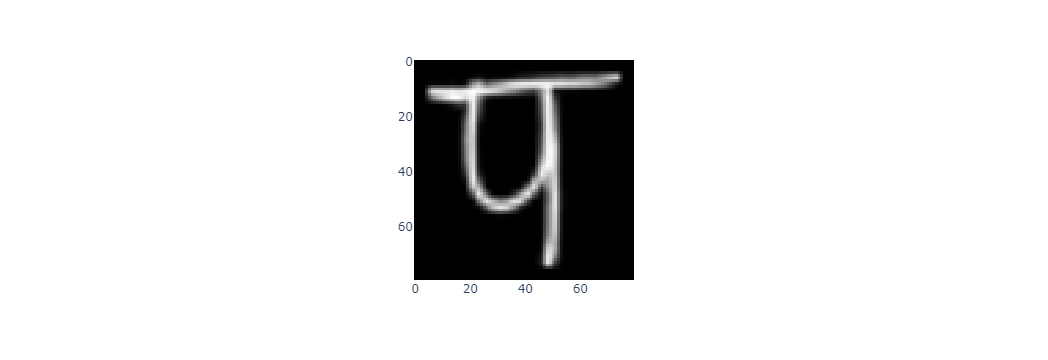

In [102]:
import plotly.express as px
px.imshow(image)

In [103]:
image.shape

(80, 80, 3)

In [104]:
# image = np.stack((image,)*3, axis=-1)
image = np.stack((image,)*3, axis=0)

In [105]:
image.shape
# image = np.array(image,dtype=np.uint8)

(3, 80, 80, 3)

In [106]:
# image

In [107]:
prediction1 = model.predict(image)

1/1 [==============================] - 0s 31ms/step


In [108]:
prediction1

array([[7.26938015e-04, 5.61786331e-02, 6.19891658e-02, 1.37135412e-05,
        1.36100207e-04, 4.03547645e-01, 6.82152750e-04, 1.79879274e-02,
        6.98048854e-04, 8.73814803e-04, 9.96871591e-02, 5.10767743e-04,
        5.10552246e-03, 6.49425026e-04, 1.58336442e-02, 1.53573463e-04,
        2.89757759e-03, 2.30850623e-04, 8.83065984e-02, 2.22750197e-04,
        2.43567973e-01],
       [7.26938015e-04, 5.61786331e-02, 6.19891658e-02, 1.37135412e-05,
        1.36100207e-04, 4.03547645e-01, 6.82152750e-04, 1.79879274e-02,
        6.98048854e-04, 8.73814803e-04, 9.96871591e-02, 5.10767743e-04,
        5.10552246e-03, 6.49425026e-04, 1.58336442e-02, 1.53573463e-04,
        2.89757759e-03, 2.30850623e-04, 8.83065984e-02, 2.22750197e-04,
        2.43567973e-01],
       [7.26937840e-04, 5.61785065e-02, 6.19891807e-02, 1.37136085e-05,
        1.36100498e-04, 4.03547734e-01, 6.82153215e-04, 1.79878958e-02,
        6.98047981e-04, 8.73812940e-04, 9.96866822e-02, 5.10765647e-04,
        5.1055

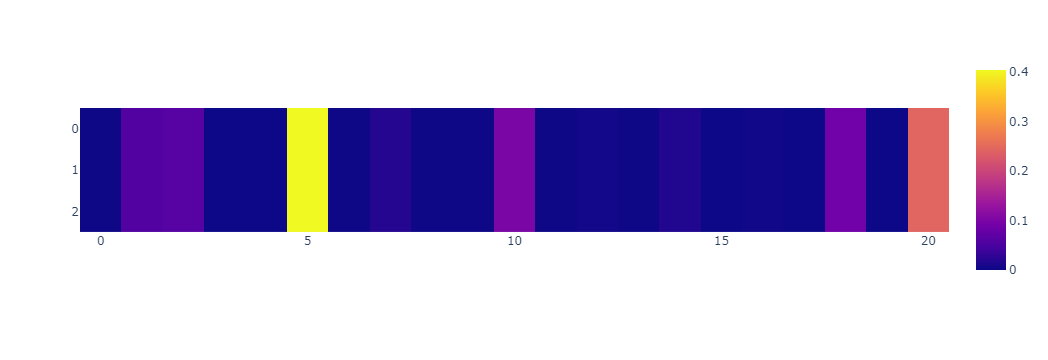

In [109]:
px.imshow(prediction1)

In [110]:
# # plot predicted images
# for i in range(col*row):
#     fig.add_subplot(grid[i])
#     img11 = load_img(test_char_path[rand[i]])
#     lbl11 = test_char_path[rand[i]].split(os.path.sep)[-2]
#     plt.title('"{:s}"'.format(lbl11))
#     plt.axis(False)
#     plt.imshow(img11)

In [111]:
print(prediction1)

[[7.26938015e-04 5.61786331e-02 6.19891658e-02 1.37135412e-05
  1.36100207e-04 4.03547645e-01 6.82152750e-04 1.79879274e-02
  6.98048854e-04 8.73814803e-04 9.96871591e-02 5.10767743e-04
  5.10552246e-03 6.49425026e-04 1.58336442e-02 1.53573463e-04
  2.89757759e-03 2.30850623e-04 8.83065984e-02 2.22750197e-04
  2.43567973e-01]
 [7.26938015e-04 5.61786331e-02 6.19891658e-02 1.37135412e-05
  1.36100207e-04 4.03547645e-01 6.82152750e-04 1.79879274e-02
  6.98048854e-04 8.73814803e-04 9.96871591e-02 5.10767743e-04
  5.10552246e-03 6.49425026e-04 1.58336442e-02 1.53573463e-04
  2.89757759e-03 2.30850623e-04 8.83065984e-02 2.22750197e-04
  2.43567973e-01]
 [7.26937840e-04 5.61785065e-02 6.19891807e-02 1.37136085e-05
  1.36100498e-04 4.03547734e-01 6.82153215e-04 1.79878958e-02
  6.98047981e-04 8.73812940e-04 9.96866822e-02 5.10765647e-04
  5.10551641e-03 6.49427297e-04 1.58335902e-02 1.53573492e-04
  2.89758388e-03 2.30851103e-04 8.83069485e-02 2.22750255e-04
  2.43568242e-01]]


In [112]:
np.argmax(prediction1)

47

In [113]:
# labels

In [114]:
# pred_name = labels.inverse_transform[np.argmax(model.predict(image[np.newaxis,:0]))]
# prediction1 = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])

In [115]:
# t1=image[np.newaxis,:]
t1=image[:]

In [116]:
t1.shape

(3, 80, 80, 3)

In [117]:
# print(t1)

In [118]:
t2 = model.predict(t1)

1/1 [==============================] - 0s 32ms/step


In [119]:
# print(t2)
title = np.array2string(t2)

In [120]:
title

'[[7.26938015e-04 5.61786331e-02 6.19891658e-02 1.37135412e-05\n  1.36100207e-04 4.03547645e-01 6.82152750e-04 1.79879274e-02\n  6.98048854e-04 8.73814803e-04 9.96871591e-02 5.10767743e-04\n  5.10552246e-03 6.49425026e-04 1.58336442e-02 1.53573463e-04\n  2.89757759e-03 2.30850623e-04 8.83065984e-02 2.22750197e-04\n  2.43567973e-01]\n [7.26938015e-04 5.61786331e-02 6.19891658e-02 1.37135412e-05\n  1.36100207e-04 4.03547645e-01 6.82152750e-04 1.79879274e-02\n  6.98048854e-04 8.73814803e-04 9.96871591e-02 5.10767743e-04\n  5.10552246e-03 6.49425026e-04 1.58336442e-02 1.53573463e-04\n  2.89757759e-03 2.30850623e-04 8.83065984e-02 2.22750197e-04\n  2.43567973e-01]\n [7.26937840e-04 5.61785065e-02 6.19891807e-02 1.37136085e-05\n  1.36100498e-04 4.03547734e-01 6.82153215e-04 1.79878958e-02\n  6.98047981e-04 8.73812940e-04 9.96866822e-02 5.10765647e-04\n  5.10551641e-03 6.49427297e-04 1.58335902e-02 1.53573492e-04\n  2.89758388e-03 2.30851103e-04 8.83069485e-02 2.22750255e-04\n  2.43568242e-01

(0.0, 1.0, 0.0, 1.0)

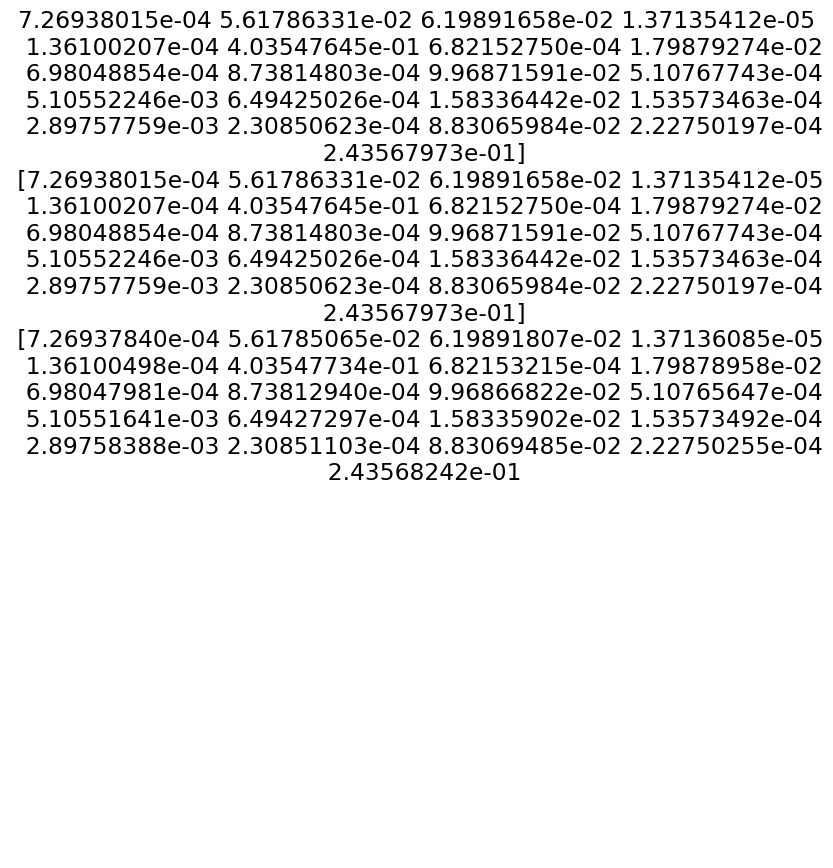

In [121]:
plt.title('{}'.format(title.strip("'[]"),fontsize=20))
plt.axis(False)

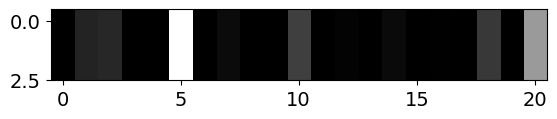

In [122]:
final_string = title.strip("'[]")
plt.imshow(t2,cmap='gray')

In [123]:
final_string

'7.26938015e-04 5.61786331e-02 6.19891658e-02 1.37135412e-05\n  1.36100207e-04 4.03547645e-01 6.82152750e-04 1.79879274e-02\n  6.98048854e-04 8.73814803e-04 9.96871591e-02 5.10767743e-04\n  5.10552246e-03 6.49425026e-04 1.58336442e-02 1.53573463e-04\n  2.89757759e-03 2.30850623e-04 8.83065984e-02 2.22750197e-04\n  2.43567973e-01]\n [7.26938015e-04 5.61786331e-02 6.19891658e-02 1.37135412e-05\n  1.36100207e-04 4.03547645e-01 6.82152750e-04 1.79879274e-02\n  6.98048854e-04 8.73814803e-04 9.96871591e-02 5.10767743e-04\n  5.10552246e-03 6.49425026e-04 1.58336442e-02 1.53573463e-04\n  2.89757759e-03 2.30850623e-04 8.83065984e-02 2.22750197e-04\n  2.43567973e-01]\n [7.26937840e-04 5.61785065e-02 6.19891807e-02 1.37136085e-05\n  1.36100498e-04 4.03547734e-01 6.82153215e-04 1.79878958e-02\n  6.98047981e-04 8.73812940e-04 9.96866822e-02 5.10765647e-04\n  5.10551641e-03 6.49427297e-04 1.58335902e-02 1.53573492e-04\n  2.89758388e-03 2.30851103e-04 8.83069485e-02 2.22750255e-04\n  2.43568242e-01'

1/1 [==============================] - 0s 35ms/step
Achieved result:  pa


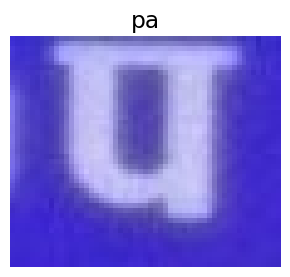

In [129]:
# pre-processing input images and pedict with model
# individual character read garnu parda yesto garney
# image_path1 = cv2.imread('../Automatic-License-Plate-Detection-khom/character_recognition/test_for_prediction/4564.png')
image_path1 = cv2.imread('../Automatic-License-Plate-Detection-khom/character_recognition/test_for_prediction/pa2.jpg')

def predict_from_model(model,labels):
    # image_path = cv2.imread('../Automatic-License-Plate-Detection-khom/character_recognition/test_for_prediction/9877.png')
    image = cv2.resize(image_path1,(80,80))
    image = np.stack((image,)*3, axis=0)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[:]))])
    return prediction
    
fig = plt.figure(figsize=(15,3))
# cols = len(crop_characters)
cols = 1
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''

fig.add_subplot(grid[0])
title = np.array2string(predict_from_model(model,labels))
plt.title('{}'.format(title.strip("'[]"),fontsize=20))
final_string+=title.strip("'[]")
plt.axis(False)
plt.imshow(image_path1,cmap='gray')

# # for i,character in enumerate(crop_characters):
# for i,character in enumerate(crop_characters):
#     fig.add_subplot(grid[i])
#     title = np.array2string(predict_from_model(character,model,labels))
#     plt.title('{}'.format(title.strip("'[]"),fontsize=20))
#     final_string+=title.strip("'[]")
#     plt.axis(False)
#     plt.imshow(character,cmap='gray')

print("Achieved result: ", final_string)
# plt.savefig('final_result.png', dpi=300)

In [127]:
# plt.imshow(final_string)

In [17]:
test_char = '../Automatic-License-Plate-Detection-khom/character_recognition/test_char/0/1.jpg'

In [20]:
import cv2
import plotly.express as px
img = cv2.imread(test_char)
fig = px.imshow(img)

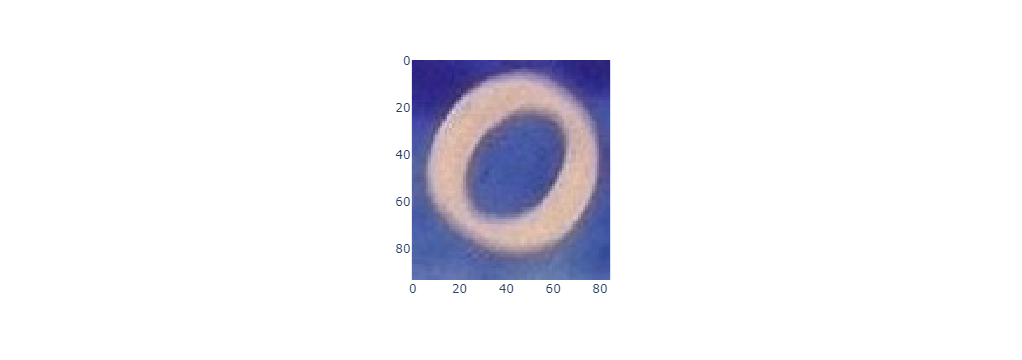

In [22]:
fig

In [40]:
col = 2
row = 3

In [41]:
fig = plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

In [42]:
plt.rcParams.update({"font.size":14})

In [43]:
grid = gridspec.GridSpec(ncols=col, nrows=row, figure=fig)

In [44]:
test_char_path = glob.glob('../Automatic-License-Plate-Detection-khom/character_recognition/test_char/**/*.jpg')


In [45]:
# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(test_char_path), size=(col*row))

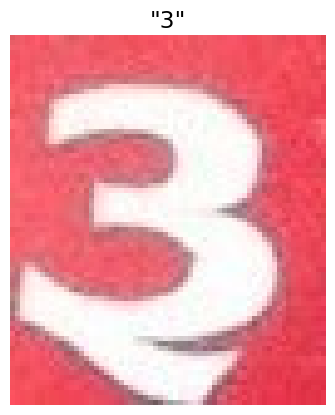

In [46]:
# plot predicted images
for i in range(col*row):
    fig.add_subplot(grid[i])
    img11 = load_img(test_char_path[rand[i]])
    lbl11 = test_char_path[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(lbl11))
    plt.axis(False)
    plt.imshow(img11)

In [ ]:

# dataset_paths = glob.glob("/content/drive/MyDrive/datasets/characters/**/*.jpg") # for google colab
dataset_paths = glob.glob('../Automatic-License-Plate-Detection-khom/character_recognition/characters/**/*.jpg')


cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot example images
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)